In [1]:
# ============================================================
#
#   KENYA DIGITAL LENDING — INVESTMENT DUE DILIGENCE
#   Notebook 01: Macroeconomic Data Cleaning & Panel Construction
#
#   Analyst:  Geoffrey Mutuku
#   Date:     February 2026
#   Purpose:  Clean and harmonise 15 raw datasets from CBK,
#             World Bank, ILO, IMF and Safaricom into a single
#             monthly macroeconomic panel for investment
#             modelling and stress test calibration.
#
#   Output:   data/clean/macro_panel_monthly.csv
#             outputs/charts/macro_panel_overview.png
#
#   Sources:
#     - Central Bank of Kenya (CBK)
#     - World Bank Open Data
#     - International Labour Organization (ILO)
#     - IMF Financial Access Survey
#     - Safaricom Annual Reports
#
# ============================================================
#
#   NOTEBOOK STRUCTURE
#   ------------------
#   Section 1: Environment setup and file upload
#   Section 2: Individual file cleaning (10 datasets)
#   Section 3: Frequency harmonisation (annual to monthly)
#   Section 4: Macro panel assembly and validation
#   Section 5: Exploratory visualisation
#   Section 6: Export to clean folder
#
# ============================================================

print("Notebook 01 — Macroeconomic Data Cleaning")
print("Kenya Digital Lending Investment Analysis")
print("=" * 50)

Notebook 01 — Macroeconomic Data Cleaning
Kenya Digital Lending Investment Analysis


In [2]:
# ============================================================
# SECTION 1: ENVIRONMENT SETUP
# ============================================================

import os
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
    print("Drive mounted")
else:
    print("Drive already mounted")

# ── Project paths ─────────────────────────────────────────
BASE   = '/content/drive/MyDrive/kenya-digital-lending-2026/'
RAW    = BASE + 'data/raw/'
CLEAN  = BASE + 'data/clean/'
CHARTS = BASE + 'outputs/charts/'
NOTES  = BASE + 'notebooks/'

# Create all folders if they do not exist
for path in [RAW, CLEAN, CHARTS, NOTES]:
    os.makedirs(path, exist_ok=True)

print(f"\nProject root: {BASE}")
print(f"Raw data:     {RAW}")
print(f"Clean data:   {CLEAN}")
print(f"Charts:       {CHARTS}")

Mounted at /content/drive
Drive mounted

Project root: /content/drive/MyDrive/kenya-digital-lending-2026/
Raw data:     /content/drive/MyDrive/kenya-digital-lending-2026/data/raw/
Clean data:   /content/drive/MyDrive/kenya-digital-lending-2026/data/clean/
Charts:       /content/drive/MyDrive/kenya-digital-lending-2026/outputs/charts/


In [3]:
# ============================================================
# Upload raw files directly from your local machine
# Click the Choose Files button that appears below
# Select ALL raw files at once using Ctrl+A
# Skip the two large Kaggle CSV files — those go in notebook 02
# ============================================================

from google.colab import files

print("Select all raw files from your local data/raw/ folder.")
print("Skip homecredit files — those go in notebook 02.")
print()

uploaded = files.upload()

print(f"\nUploaded {len(uploaded)} files. Saving to Drive...")

for filename, content in uploaded.items():
    dest = RAW + filename
    with open(dest, 'wb') as f:
        f.write(content)
    size_mb = len(content) / (1024 * 1024)
    print(f"  ✓ {filename:55} {size_mb:.1f} MB")

print(f"\nAll files saved to {RAW}")

Select all raw files from your local data/raw/ folder.
Skip homecredit files — those go in notebook 02.



Saving knbs_inflation_raw.xlsx to knbs_inflation_raw.xlsx
Saving cbk_lending_rate_raw.xlsx to cbk_lending_rate_raw.xlsx
Saving cbk_private_credit_raw.xlsx to cbk_private_credit_raw.xlsx
Saving cbk_policy_rate_raw.xlsx to cbk_policy_rate_raw.xlsx
Saving knbs_unemployment_raw.xlsx to knbs_unemployment_raw.xlsx
Saving mpesa_metrics_raw.xlsx to mpesa_metrics_raw.xlsx
Saving imf_financial_access_raw.csv to imf_financial_access_raw.csv
Saving wb_interest_spread_raw.xls to wb_interest_spread_raw.xls
Saving wb_credit_gdp_raw.xls to wb_credit_gdp_raw.xls
Saving wb_gdp_per_capita_raw.xls to wb_gdp_per_capita_raw.xls
Saving knbs_income_raw.xlsx to knbs_income_raw.xlsx
Saving knbs_population_working_age_pct_raw.xls to knbs_population_working_age_pct_raw.xls
Saving knbs_population_total_raw.xls to knbs_population_total_raw.xls
Saving knbs_gdp_raw.xls to knbs_gdp_raw.xls
Saving cbk_npl_ratio_raw.xlsx to cbk_npl_ratio_raw.xlsx
Saving homecredit_application_train_raw.csv to homecredit_application_trai

In [4]:
# ============================================================
# Verify all expected files are present before cleaning
# This is a professional practice — never assume files exist
# ============================================================

EXPECTED_FILES = {
    'cbk_lending_rate_raw.xlsx':                 'CBK Lending Rate',
    'cbk_npl_ratio_raw.xlsx':                    'CBK NPL Ratio (WB proxy)',
    'cbk_private_credit_raw.xlsx':               'CBK Private Credit',
    'cbk_policy_rate_raw.xlsx':                  'CBK Policy Rate',
    'knbs_unemployment_raw.xlsx':                'ILO Unemployment',
    'knbs_inflation_raw.xlsx':                   'WB Inflation',
    'knbs_gdp_raw.xls':                          'WB GDP Growth',
    'knbs_population_total_raw.xls':             'WB Population Total',
    'knbs_population_working_age_pct_raw.xls':   'WB Working Age %',
    'knbs_income_raw.xlsx':                      'Income Distribution',
    'wb_gdp_per_capita_raw.xls':                 'WB GDP (Total)',
    'wb_credit_gdp_raw.xls':                     'WB Credit % GDP',
    'wb_interest_spread_raw.xls':                'WB Interest Spread',
    'imf_financial_access_raw.csv':              'IMF Financial Access',
    'mpesa_metrics_raw.xlsx':                    'Safaricom M-Pesa',
}

print("FILE MANIFEST VERIFICATION")
print("=" * 65)

all_present = True
for filename, description in EXPECTED_FILES.items():
    path = RAW + filename
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"  ✓ {description:40} {size_mb:6.1f} MB")
    else:
        print(f"  ✗ {description:40} MISSING — {filename}")
        all_present = False

print()
if all_present:
    print("All files present. Proceeding to cleaning.")
else:
    print("WARNING: Some files missing. Upload before continuing.")

FILE MANIFEST VERIFICATION
  ✓ CBK Lending Rate                            0.0 MB
  ✓ CBK NPL Ratio (WB proxy)                    0.1 MB
  ✓ CBK Private Credit                          0.1 MB
  ✓ CBK Policy Rate                             0.0 MB
  ✓ ILO Unemployment                            1.1 MB
  ✓ WB Inflation                                0.2 MB
  ✓ WB GDP Growth                               0.4 MB
  ✓ WB Population Total                         0.2 MB
  ✓ WB Working Age %                            0.4 MB
  ✓ Income Distribution                         0.0 MB
  ✓ WB GDP (Total)                              0.4 MB
  ✓ WB Credit % GDP                             0.3 MB
  ✓ WB Interest Spread                          0.2 MB
  ✓ IMF Financial Access                       25.3 MB
  ✓ Safaricom M-Pesa                            0.0 MB

All files present. Proceeding to cleaning.


In [5]:
# ============================================================
# All libraries used in this notebook
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 20)
%matplotlib inline

# ── Plot style ────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor':  '#0a0d14',
    'axes.facecolor':    '#0f1420',
    'axes.edgecolor':    '#1c2336',
    'axes.labelcolor':   '#c8d4f0',
    'xtick.color':       '#6a7898',
    'ytick.color':       '#6a7898',
    'text.color':        '#c8d4f0',
    'grid.color':        '#1c2336',
    'grid.linestyle':    '--',
    'grid.alpha':        0.5,
    'font.family':       'monospace',
    'figure.titlesize':  13,
    'axes.titlesize':    11,
    'axes.labelsize':    9,
})

COLORS = {
    'green':  '#00d4a0',
    'amber':  '#f0a500',
    'red':    '#e84040',
    'blue':   '#3a7bd5',
    'muted':  '#4a5578',
    'dim':    '#6a7898',
}

print("Libraries loaded")
print(f"  pandas  {pd.__version__}")
print(f"  numpy   {np.__version__}")

Libraries loaded
  pandas  2.2.2
  numpy   2.0.2


In [6]:
# ============================================================
# SECTION 2: FILE CLEANING
# Helper functions used across all cleaning steps
# ============================================================

def section(title):
    print(f"\n{'='*60}\n  {title}\n{'='*60}")

def quality_report(df_or_series, name):
    """
    Prints a structured quality report after each cleaning step.
    Mirrors the data quality documentation standard used in
    MBB due diligence data rooms.
    """
    print(f"\n  Quality Report — {name}")
    print(f"  {'-'*40}")
    if isinstance(df_or_series, pd.Series):
        print(f"  Type:       Series")
        print(f"  Length:     {len(df_or_series)}")
        print(f"  Index:      {df_or_series.index.min()} "
              f"to {df_or_series.index.max()}")
        print(f"  Nulls:      {df_or_series.isnull().sum()}")
        print(f"  Min:        {df_or_series.min():.3f}")
        print(f"  Max:        {df_or_series.max():.3f}")
        print(f"  Latest:     {df_or_series.iloc[-1]:.3f}")
    else:
        print(f"  Type:       DataFrame")
        print(f"  Shape:      {df_or_series.shape}")
        print(f"  Columns:    {df_or_series.columns.tolist()}")
        null_cols = df_or_series.isnull().sum()
        null_cols = null_cols[null_cols > 0]
        if len(null_cols) > 0:
            print(f"  Nulls:\n{null_cols}")
        else:
            print(f"  Nulls:      None")

def annual_to_monthly(annual_series, monthly_index,
                      method='linear'):
    """
    Converts annual pandas Series to monthly frequency.

    Method: Linear interpolation between annual observations.
    Edge gaps filled with forward/back fill.

    This is the standard approach for macro panel construction
    in investment modelling when monthly source data is
    unavailable.
    """
    ts_index = pd.to_datetime(
        [f'{yr}-01-01' for yr in annual_series.index]
    )
    series_ts = pd.Series(
        annual_series.values,
        index=ts_index,
        name=annual_series.name
    )
    series_monthly = series_ts.reindex(
        series_ts.index.union(monthly_index)
    ).sort_index()
    series_monthly = series_monthly.interpolate(method=method)
    series_monthly = series_monthly.ffill().bfill()
    series_monthly = series_monthly.reindex(monthly_index)
    return series_monthly

def extract_kenya_from_wb(filename, indicator_label):
    """
    Extracts Kenya time series from any World Bank download.

    Handles both file structures encountered in this project:
    - Files with a Country Name header row
    - Files without a header row (years assigned manually)

    Returns a pandas Series indexed by integer year.
    """
    print(f"  Loading: {filename}")

    # Read without assumptions about header
    ext = filename.split('.')[-1].lower()
    if ext == 'csv':
        df_raw = pd.read_csv(RAW + filename, header=None)
    else:
        df_raw = pd.read_excel(RAW + filename, header=None)

    # Search for Country Name header row
    header_row = None
    for i in range(min(10, len(df_raw))):
        if 'Country Name' in [str(v) for v in df_raw.iloc[i].values]:
            header_row = i
            break

    if header_row is not None:
        df_raw.columns = df_raw.iloc[header_row].values
        df_data = df_raw.iloc[header_row + 1:].reset_index(drop=True)
        df_kenya = df_data[
            df_data['Country Name'].astype(str).str.strip() == 'Kenya'
        ].copy()
        if len(df_kenya) == 0:
            df_kenya = df_data[
                df_data['Country Code'].astype(str).str.strip() == 'KEN'
            ].copy()
        year_cols = df_data.columns[4:]
    else:
        df_data = df_raw.iloc[4:].reset_index(drop=True)
        n = df_data.shape[1] - 4
        year_labels = list(range(1960, 1960 + n))
        col_names = ['country_name', 'country_code',
                     'indicator_name', 'indicator_code'] + year_labels
        df_data.columns = col_names[:df_data.shape[1]]
        df_kenya = df_data[
            df_data['country_code'].astype(str).str.strip() == 'KEN'
        ].copy()
        if len(df_kenya) == 0:
            df_kenya = df_data[
                df_data['country_name'].astype(str).str.strip() == 'Kenya'
            ].copy()
        year_cols = [c for c in df_data.columns
                     if isinstance(c, (int, float))]

    if len(df_kenya) == 0:
        print(f"  WARNING: Kenya not found in {filename}")
        return None

    kenya_row = df_kenya.iloc[0]
    years, values = [], []
    for col in year_cols:
        try:
            yr = int(float(str(col)))
            val = float(kenya_row[col])
            years.append(yr)
            values.append(val)
        except:
            pass

    result = pd.Series(
        values, index=years, name=indicator_label
    ).dropna()

    print(f"  Kenya: {len(result)} years  "
          f"({result.index.min()}–{result.index.max()})  "
          f"Latest: {result.iloc[-1]:.2f}")
    return result

print("Helper functions defined")

Helper functions defined


In [7]:
# ────────────────────────────────────────────────────────────
# CBK LENDING RATE
# Source: Central Bank of Kenya — Interest Rates
# Structure: Year (int) + Month (str) + rate columns
# ────────────────────────────────────────────────────────────

section("CBK LENDING RATE")

lr_raw = pd.read_excel(RAW + 'cbk_lending_rate_raw.xlsx')

# Combine separate Year and Month columns into datetime
lr_raw['date'] = pd.to_datetime(
    lr_raw['Year'].astype(str) + ' ' + lr_raw['Month'],
    format='%Y %B'
)

# Keep relevant columns and rename
lr_clean = lr_raw[['date','Lending','Deposit']].copy()
lr_clean.columns = ['date','lending_rate','deposit_rate']

# Sort chronologically and set date index
lr_clean = (lr_clean
            .sort_values('date')
            .drop_duplicates(subset='date', keep='first')
            .set_index('date'))

quality_report(lr_clean, 'CBK Lending Rate')


  CBK LENDING RATE

  Quality Report — CBK Lending Rate
  ----------------------------------------
  Type:       DataFrame
  Shape:      (143, 2)
  Columns:    ['lending_rate', 'deposit_rate']
  Nulls:      None


In [8]:
# ────────────────────────────────────────────────────────────
# CBK POLICY RATE (Central Bank Rate)
# Source: Central Bank of Kenya — Monetary Policy
# Structure: MPC decision dates — not monthly
# Method: Forward fill between MPC meeting dates
# ────────────────────────────────────────────────────────────

section("CBK POLICY RATE")

pr_raw = pd.read_excel(RAW + 'cbk_policy_rate_raw.xlsx')
pr_raw.columns = ['date', 'policy_rate']
pr_raw['date'] = pd.to_datetime(pr_raw['date'])
pr_raw = pr_raw.drop_duplicates(subset='date', keep='first')
pr_raw = pr_raw.sort_values('date')

# Snap each MPC date to month start then forward fill
pr_raw['date'] = pr_raw['date'].dt.to_period('M').dt.to_timestamp()
pr_raw = pr_raw.drop_duplicates(subset='date', keep='first')
pr_raw = pr_raw.set_index('date')

# Reindex to full monthly range and forward fill
monthly_index = pd.date_range(
    start='2014-01-01', end='2025-11-01', freq='MS'
)
pr_clean = pr_raw.reindex(monthly_index).ffill().bfill()
pr_clean.index.name = 'date'

quality_report(pr_clean, 'CBK Policy Rate')


  CBK POLICY RATE

  Quality Report — CBK Policy Rate
  ----------------------------------------
  Type:       DataFrame
  Shape:      (143, 1)
  Columns:    ['policy_rate']
  Nulls:      None


In [9]:
# ────────────────────────────────────────────────────────────
# CBK PRIVATE CREDIT
# Source: CBK Banking Survey (Section C — Depository
#         Corporation Survey, consolidated)
# Target row: Row 89 — "Claims on Private sector"
# Structure: 3 header rows then monthly data in wide format
# ────────────────────────────────────────────────────────────

section("CBK PRIVATE CREDIT")

pc_raw = pd.read_excel(
    RAW + 'cbk_private_credit_raw.xlsx', header=None
)

# Row 0 = year labels
# Row 1 = units label (KSHS M) — skip
# Row 2 = month abbreviations
year_row  = pc_raw.iloc[0, :].tolist()
month_row = pc_raw.iloc[2, :].tolist()

MONTH_MAP = {
    'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
    'Jul':7,'Aug':8,'Sep':9,'Sept':9,'Oct':10,
    'Nov':11,'Dec':12
}

# Reconstruct date for each column
col_dates = []
current_year = None
for col_idx in range(len(year_row)):
    try:
        yr = int(float(str(year_row[col_idx]).strip()))
        if 2000 <= yr <= 2030:
            current_year = yr
    except:
        pass
    month_val = str(month_row[col_idx]).strip()
    if current_year and month_val in MONTH_MAP:
        col_dates.append((
            col_idx,
            pd.Timestamp(year=current_year,
                         month=MONTH_MAP[month_val], day=1)
        ))

print(f"  Date columns mapped: {len(col_dates)}")
print(f"  Range: {col_dates[0][1].date()} "
      f"to {col_dates[-1][1].date()}")

# Extract Row 89 — Claims on Private Sector
TARGET_ROW = 89
label = pc_raw.iloc[TARGET_ROW, 1]
print(f"  Target row label: '{label}'")

dates, values = [], []
for col_idx, date in col_dates:
    try:
        val = float(
            str(pc_raw.iloc[TARGET_ROW, col_idx])
            .replace(',','').strip()
        )
        dates.append(date)
        values.append(val)
    except:
        dates.append(date)
        values.append(np.nan)

private_credit_monthly = pd.Series(
    values,
    index=pd.DatetimeIndex(dates),
    name='private_credit_kes_m'
).sort_index()

quality_report(private_credit_monthly, 'CBK Private Credit')


  CBK PRIVATE CREDIT
  Date columns mapped: 143
  Range: 2014-01-01 to 2025-11-01
  Target row label: 'Claims on Private sector'

  Quality Report — CBK Private Credit
  ----------------------------------------
  Type:       Series
  Length:     143
  Index:      2014-01-01 00:00:00 to 2025-11-01 00:00:00
  Nulls:      0
  Min:        1706788.000
  Max:        5070525.865
  Latest:     5070525.865


In [10]:
# ────────────────────────────────────────────────────────────
# WORLD BANK & PROXY SOURCES
# NPL Ratio, Inflation, GDP Growth, GDP Total,
# Credit % GDP, Interest Spread, Population x2
# ────────────────────────────────────────────────────────────

section("WORLD BANK AND PROXY FILES")

npl_annual = extract_kenya_from_wb(
    'cbk_npl_ratio_raw.xlsx', 'npl_ratio')

inflation_annual = extract_kenya_from_wb(
    'knbs_inflation_raw.xlsx', 'inflation')

gdp_growth_annual = extract_kenya_from_wb(
    'knbs_gdp_raw.xls', 'gdp_growth')

gdp_total_annual = extract_kenya_from_wb(
    'wb_gdp_per_capita_raw.xls', 'gdp_total_usd')

credit_gdp_annual = extract_kenya_from_wb(
    'wb_credit_gdp_raw.xls', 'credit_gdp_pct')

spread_annual = extract_kenya_from_wb(
    'wb_interest_spread_raw.xls', 'interest_spread')

pop_total_annual = extract_kenya_from_wb(
    'knbs_population_total_raw.xls', 'population_total')

pop_pct_annual = extract_kenya_from_wb(
    'knbs_population_working_age_pct_raw.xls', 'working_age_pct')

# ── Derive GDP per capita ──────────────────────────────────
common = gdp_total_annual.index.intersection(pop_total_annual.index)
gdp_pc_annual = (
    gdp_total_annual[common] / pop_total_annual[common]
).rename('gdp_per_capita_usd')
print(f"\n  Derived GDP per capita — "
      f"latest: ${gdp_pc_annual.iloc[-1]:,.0f}")

# ── Derive adult population ───────────────────────────────
common2 = pop_total_annual.index.intersection(pop_pct_annual.index)
adult_pop_annual = (
    pop_total_annual[common2] * pop_pct_annual[common2] / 100
).rename('adult_population')
print(f"  Derived adult population — "
      f"latest: {adult_pop_annual.iloc[-1]/1e6:.1f}M")


  WORLD BANK AND PROXY FILES
  Loading: cbk_npl_ratio_raw.xlsx
  Kenya: 18 years  (2006–2023)  Latest: 12.34
  Loading: knbs_inflation_raw.xlsx
  Kenya: 65 years  (1960–2024)  Latest: 4.49
  Loading: knbs_gdp_raw.xls
  Kenya: 64 years  (1961–2024)  Latest: 4.72
  Loading: wb_gdp_per_capita_raw.xls
  Kenya: 65 years  (1960–2024)  Latest: 120339557905.93
  Loading: wb_credit_gdp_raw.xls
  Kenya: 63 years  (1961–2023)  Latest: 31.80
  Loading: wb_interest_spread_raw.xls
  Kenya: 51 years  (1971–2023)  Latest: 4.42
  Loading: knbs_population_total_raw.xls
  Kenya: 65 years  (1960–2024)  Latest: 56432944.00
  Loading: knbs_population_working_age_pct_raw.xls
  Kenya: 65 years  (1960–2024)  Latest: 60.20

  Derived GDP per capita — latest: $2,132
  Derived adult population — latest: 34.0M


In [11]:
# ────────────────────────────────────────────────────────────
# ILO UNEMPLOYMENT
# Source: ILO modelled estimates
# Filter: Kenya | Total (both sexes) | Age 15+
# ────────────────────────────────────────────────────────────

section("ILO UNEMPLOYMENT")

unemp_raw = pd.read_excel(RAW + 'knbs_unemployment_raw.xlsx')
print(f"  Raw shape: {unemp_raw.shape}")

# Filter step by step for transparency
unemp_kenya = unemp_raw[
    unemp_raw['ref_area.label'].str.contains(
        'Kenya', case=False, na=False)
].copy()
print(f"  Kenya rows: {len(unemp_kenya)}")

unemp_kenya = unemp_kenya[
    unemp_kenya['sex.label'] == 'Total'
].copy()
print(f"  After sex=Total filter: {len(unemp_kenya)}")

# Age 15+ filter
unemp_15plus = unemp_kenya[
    unemp_kenya['classif1.label'].str.contains(
        '15\+', case=False, na=False)
].copy()

if len(unemp_15plus) == 0:
    # Fallback — take broadest age group available
    print("  15+ filter returned 0 rows — using broadest group")
    age_groups = unemp_kenya['classif1.label'].unique()
    print(f"  Available age groups: {age_groups}")
    unemp_15plus = unemp_kenya.copy()

# Keep year and value only
unemp_annual = (unemp_15plus[['time','obs_value']]
                .rename(columns={'time':'year',
                                 'obs_value':'unemployment'})
                .dropna(subset=['unemployment'])
                .drop_duplicates(subset='year', keep='first')
                .sort_values('year')
                .set_index('year')['unemployment'])

quality_report(unemp_annual, 'ILO Unemployment')


  ILO UNEMPLOYMENT
  Raw shape: (30012, 11)
  Kenya rows: 36
  After sex=Total filter: 12

  Quality Report — ILO Unemployment
  ----------------------------------------
  Type:       Series
  Length:     4
  Index:      2016 to 2022
  Nulls:      0
  Min:        2.757
  Max:        5.585
  Latest:     5.441


In [12]:
# ────────────────────────────────────────────────────────────
# IMF FINANCIAL ACCESS SURVEY
# Source: IMF FAS — Kenya indicators
# File type: CSV
# ────────────────────────────────────────────────────────────

section("IMF FINANCIAL ACCESS SURVEY")

imf_raw = pd.read_csv(
    RAW + 'imf_financial_access_raw.csv', low_memory=False
)
print(f"  Raw shape: {imf_raw.shape}")

# Filter to Kenya
imf_kenya = imf_raw[
    imf_raw['COUNTRY'].str.contains('Kenya', case=False, na=False)
].copy()
print(f"  Kenya rows: {len(imf_kenya)}")

# Identify year columns
year_cols = [c for c in imf_raw.columns
             if str(c).isdigit() and 2000 <= int(c) <= 2030]
print(f"  Year range: {year_cols[0]} to {year_cols[-1]}")

# Extract all Kenya series into a dictionary
imf_series_dict = {}
for _, row in imf_kenya.iterrows():
    code = str(row.get('SERIES_CODE', '')).strip()
    indicator = str(row.get('INDICATOR', '')).strip()
    years, vals = [], []
    for yr_col in year_cols:
        try:
            vals.append(float(row[yr_col]))
            years.append(int(yr_col))
        except:
            pass
    s = pd.Series(vals, index=years, name=code).dropna()
    if len(s) > 0:
        imf_series_dict[code] = s

print(f"\n  Kenya series extracted: {len(imf_series_dict)}")
print(f"  Series codes available:")
for code, s in imf_series_dict.items():
    print(f"    {code:30} {len(s)} years  "
          f"latest: {s.iloc[-1]:.3f}")


  IMF FINANCIAL ACCESS SURVEY
  Raw shape: (8208, 116)
  Kenya rows: 39
  Year range: 2000 to 2030

  Kenya series extracted: 39
  Series codes available:
    KEN.GGXWDN.A                   31 years  latest: 19321.909
    KEN.GGXCNL_NGDP.A              31 years  latest: -4.746
    KEN.LP.A                       31 years  latest: 57.976
    KEN.NGDPDPC.A                  31 years  latest: 2864.660
    KEN.BCA_NGDPD.A                31 years  latest: -2.997
    KEN.GGXONLB_NGDP.A             31 years  latest: 0.485
    KEN.NGDP_D.A                   31 years  latest: 196.020
    KEN.PPPEX.A                    31 years  latest: 50.986
    KEN.PPPSH.A                    31 years  latest: 0.211
    KEN.NID_NGDP.A                 31 years  latest: 19.175
    KEN.PPPGDP.A                   31 years  latest: 560.364
    KEN.NGDPPC.A                   31 years  latest: 492804.625
    KEN.GGR_NGDP.A                 31 years  latest: 18.059
    KEN.NGDPD.A                    31 years  latest: 16

In [13]:
# ────────────────────────────────────────────────────────────
# SECTION 3: FREQUENCY HARMONISATION
#
# All annual series are interpolated to monthly frequency.
# Method: Linear interpolation between annual observations.
#
# Rationale: The loan cashflow model in Excel operates on
# monthly timesteps. All macro drivers must align to the
# same frequency to allow direct linkage in the stress test.
# ────────────────────────────────────────────────────────────

section("FREQUENCY HARMONISATION — ANNUAL TO MONTHLY")

MONTHLY_INDEX = pd.date_range(
    start='2014-01-01', end='2025-11-01', freq='MS'
)
print(f"Target range: 2014-01 to 2025-11 ({len(MONTHLY_INDEX)} months)")
print()

conversions = {
    'npl_ratio':          npl_annual,
    'inflation':          inflation_annual,
    'gdp_growth':         gdp_growth_annual,
    'gdp_per_capita_usd': gdp_pc_annual,
    'credit_gdp_pct':     credit_gdp_annual,
    'interest_spread':    spread_annual,
    'population_total':   pop_total_annual,
    'adult_population':   adult_pop_annual,
    'unemployment':       unemp_annual,
}

monthly_series = {}
for name, series in conversions.items():
    m = annual_to_monthly(series, MONTHLY_INDEX)
    monthly_series[name] = m
    nulls = m.isnull().sum()
    status = "OK" if nulls == 0 else f"WARNING {nulls} nulls"
    print(f"  {name:30} {len(m):4} months  "
          f"latest: {m.iloc[-1]:>10.2f}  {status}")


  FREQUENCY HARMONISATION — ANNUAL TO MONTHLY
Target range: 2014-01 to 2025-11 (143 months)

  npl_ratio                       143 months  latest:      12.34  OK
  inflation                       143 months  latest:       4.49  OK
  gdp_growth                      143 months  latest:       4.72  OK
  gdp_per_capita_usd              143 months  latest:    2132.43  OK
  credit_gdp_pct                  143 months  latest:      31.80  OK
  interest_spread                 143 months  latest:       4.42  OK
  population_total                143 months  latest: 56432944.00  OK
  adult_population                143 months  latest: 33971375.70  OK
  unemployment                    143 months  latest:       5.44  OK


In [14]:
# ────────────────────────────────────────────────────────────
# SECTION 4: MACRO PANEL ASSEMBLY
#
# Combine all cleaned series into one master dataframe.
# Add engineered features used in stress test calibration.
# ────────────────────────────────────────────────────────────

section("MACRO PANEL ASSEMBLY")

# ── Align CBK series to monthly index ────────────────────
lr_aligned  = lr_clean['lending_rate'].reindex(
    MONTHLY_INDEX).ffill().bfill()
dep_aligned = lr_clean['deposit_rate'].reindex(
    MONTHLY_INDEX).ffill().bfill()
pr_aligned  = pr_clean['policy_rate'].reindex(
    MONTHLY_INDEX).ffill().bfill()
pc_aligned  = private_credit_monthly.reindex(
    MONTHLY_INDEX).ffill().bfill()

# ── Build master dataframe ────────────────────────────────
macro_panel = pd.DataFrame({
    # Interest rate environment
    'lending_rate':         lr_aligned.values,
    'deposit_rate':         dep_aligned.values,
    'policy_rate':          pr_aligned.values,
    'interest_spread':      monthly_series['interest_spread'].values,

    # Credit quality
    'npl_ratio':            monthly_series['npl_ratio'].values,

    # Macro growth
    'inflation':            monthly_series['inflation'].values,
    'gdp_growth':           monthly_series['gdp_growth'].values,
    'gdp_per_capita_usd':   monthly_series['gdp_per_capita_usd'].values,

    # Credit market
    'credit_gdp_pct':       monthly_series['credit_gdp_pct'].values,
    'private_credit_kes_m': pc_aligned.values,

    # Labour market
    'unemployment':         monthly_series['unemployment'].values,

    # Population
    'population_total':     monthly_series['population_total'].values,
    'adult_population':     monthly_series['adult_population'].values,

}, index=MONTHLY_INDEX)
macro_panel.index.name = 'date'

# ── Engineered features for stress test calibration ──────
# Credit growth YoY — primary stress test driver
macro_panel['credit_growth_yoy'] = (
    macro_panel['private_credit_kes_m'].pct_change(12) * 100
)

# Real lending rate = nominal rate minus inflation
# Negative real rates signal financial repression
macro_panel['real_lending_rate'] = (
    macro_panel['lending_rate'] - macro_panel['inflation']
)

# Monthly policy rate change — signals tightening cycles
macro_panel['policy_rate_mom_change'] = (
    macro_panel['policy_rate'].diff()
)

# NPL change YoY — early warning indicator
macro_panel['npl_change_yoy'] = (
    macro_panel['npl_ratio'].diff(12)
)

print(f"Macro panel assembled:")
print(f"  Shape:       {macro_panel.shape}")
print(f"  Date range:  {macro_panel.index.min().date()} "
      f"to {macro_panel.index.max().date()}")
print(f"  Columns:     {len(macro_panel.columns)}")
print()

# Column summary
print(f"{'Column':30} {'Nulls':>6}  {'Min':>10}  "
      f"{'Max':>10}  {'Latest':>10}")
print("-" * 72)
for col in macro_panel.columns:
    nulls  = macro_panel[col].isnull().sum()
    mn     = macro_panel[col].min()
    mx     = macro_panel[col].max()
    latest = macro_panel[col].dropna().iloc[-1]
    print(f"  {col:28} {nulls:>6}  {mn:>10.2f}  "
          f"{mx:>10.2f}  {latest:>10.2f}")


  MACRO PANEL ASSEMBLY
Macro panel assembled:
  Shape:       (143, 17)
  Date range:  2014-01-01 to 2025-11-01
  Columns:     17

Column                          Nulls         Min         Max      Latest
------------------------------------------------------------------------
  lending_rate                      0       11.75       18.30       14.88
  deposit_rate                      0        6.26       11.48        7.28
  policy_rate                       0        7.00       13.00        9.25
  interest_spread                   0        4.42        8.14        4.42
  npl_ratio                         0        5.46       12.34       12.34
  inflation                         0        4.49        8.01        4.49
  gdp_growth                        0       -0.27        7.59        4.72
  gdp_per_capita_usd                0     1482.82     2132.43     2132.43
  credit_gdp_pct                    0       30.83       36.70       31.80
  private_credit_kes_m              0  1706788.00  50705


  MACRO PANEL VISUALISATION


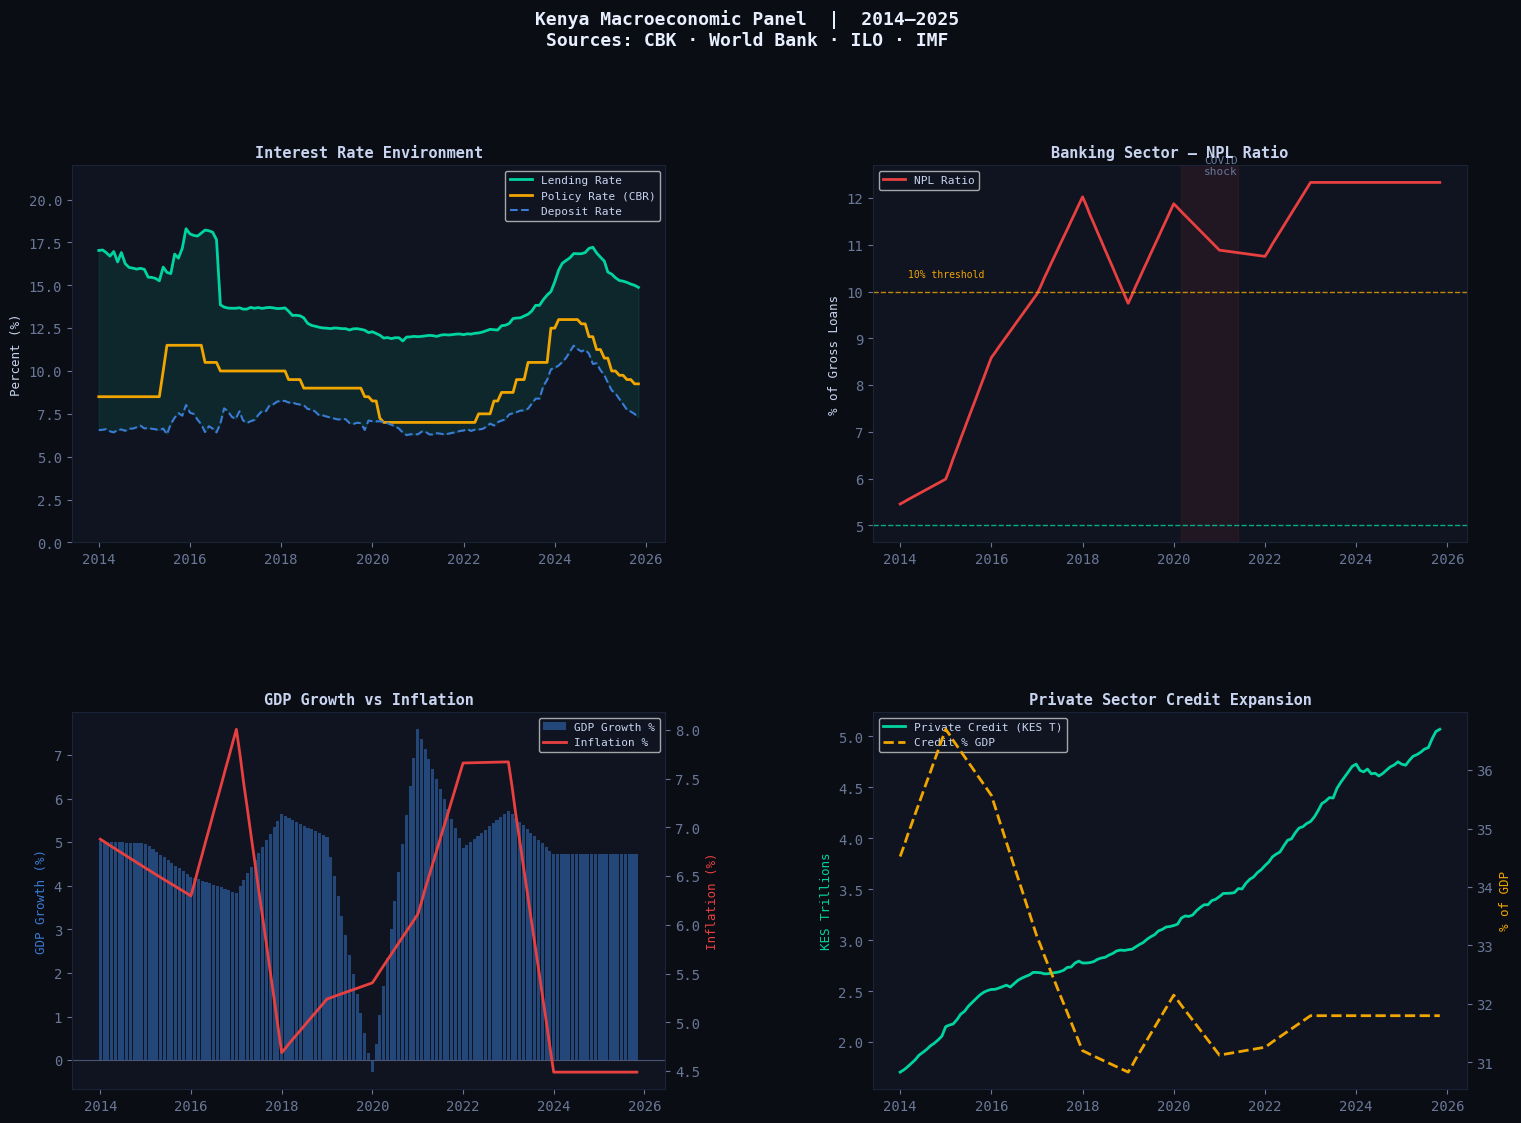

Chart saved: /content/drive/MyDrive/kenya-digital-lending-2026/outputs/charts/macro_panel_overview.png


In [15]:
# ────────────────────────────────────────────────────────────
# SECTION 5: EXPLORATORY VISUALISATION
#
# Four-panel chart for investment committee presentation.
# This chart goes directly into your GitHub README
# and LinkedIn post 1.
# ────────────────────────────────────────────────────────────

section("MACRO PANEL VISUALISATION")

fig = plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('#0a0d14')
gs = gridspec.GridSpec(2, 2, figure=fig,
                        hspace=0.45, wspace=0.35)

# ── Panel 1 — Interest Rate Environment ──────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(macro_panel.index,
         macro_panel['lending_rate'],
         color=COLORS['green'], linewidth=2,
         label='Lending Rate')
ax1.plot(macro_panel.index,
         macro_panel['policy_rate'],
         color=COLORS['amber'], linewidth=2,
         label='Policy Rate (CBR)')
ax1.plot(macro_panel.index,
         macro_panel['deposit_rate'],
         color=COLORS['blue'], linewidth=1.5,
         linestyle='--', label='Deposit Rate')
ax1.fill_between(macro_panel.index,
                 macro_panel['deposit_rate'],
                 macro_panel['lending_rate'],
                 alpha=0.1, color=COLORS['green'])
ax1.set_title('Interest Rate Environment', fontweight='bold')
ax1.set_ylabel('Percent (%)')
ax1.legend(fontsize=8, loc='upper right')
ax1.set_ylim(0, 22)

# ── Panel 2 — Credit Quality ──────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(macro_panel.index,
         macro_panel['npl_ratio'],
         color=COLORS['red'], linewidth=2,
         label='NPL Ratio')
ax2.axhline(y=10, color=COLORS['amber'],
            linestyle='--', alpha=0.8, linewidth=1)
ax2.axhline(y=5, color=COLORS['green'],
            linestyle='--', alpha=0.8, linewidth=1)
ax2.axvspan(pd.Timestamp('2020-03-01'),
            pd.Timestamp('2021-06-01'),
            alpha=0.08, color=COLORS['red'])
ax2.annotate('COVID\nshock',
             xy=(pd.Timestamp('2020-09-01'), 12.5),
             color=COLORS['dim'], fontsize=8)
ax2.annotate('10% threshold',
             xy=(pd.Timestamp('2014-03-01'), 10.3),
             color=COLORS['amber'], fontsize=7)
ax2.set_title('Banking Sector — NPL Ratio', fontweight='bold')
ax2.set_ylabel('% of Gross Loans')
ax2.legend(fontsize=8)

# ── Panel 3 — Growth vs Inflation ─────────────────────────
ax3 = fig.add_subplot(gs[1, 0])
ax3_r = ax3.twinx()
ax3.bar(macro_panel.index,
        macro_panel['gdp_growth'],
        color=COLORS['blue'], alpha=0.5,
        width=25, label='GDP Growth %')
ax3_r.plot(macro_panel.index,
           macro_panel['inflation'],
           color=COLORS['red'], linewidth=2,
           label='Inflation %')
ax3.axhline(y=0, color=COLORS['muted'],
            linewidth=0.8, linestyle='-')
ax3.set_title('GDP Growth vs Inflation', fontweight='bold')
ax3.set_ylabel('GDP Growth (%)', color=COLORS['blue'])
ax3_r.set_ylabel('Inflation (%)', color=COLORS['red'])
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_r.get_legend_handles_labels()
ax3.legend(lines1+lines2, labels1+labels2,
           fontsize=8, loc='upper right')

# ── Panel 4 — Credit Expansion ────────────────────────────
ax4 = fig.add_subplot(gs[1, 1])
ax4_r = ax4.twinx()
ax4.plot(macro_panel.index,
         macro_panel['private_credit_kes_m'] / 1e6,
         color=COLORS['green'], linewidth=2,
         label='Private Credit (KES T)')
ax4_r.plot(macro_panel.index,
           macro_panel['credit_gdp_pct'],
           color=COLORS['amber'], linewidth=2,
           linestyle='--', label='Credit % GDP')
ax4.set_title('Private Sector Credit Expansion',
              fontweight='bold')
ax4.set_ylabel('KES Trillions', color=COLORS['green'])
ax4_r.set_ylabel('% of GDP', color=COLORS['amber'])
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_r.get_legend_handles_labels()
ax4.legend(lines1+lines2, labels1+labels2,
           fontsize=8, loc='upper left')

fig.suptitle(
    'Kenya Macroeconomic Panel  |  2014–2025\n'
    'Sources: CBK · World Bank · ILO · IMF',
    fontsize=13, fontweight='bold', y=1.01,
    color='#e8f0ff'
)

plt.savefig(CHARTS + 'macro_panel_overview.png',
            dpi=150, bbox_inches='tight',
            facecolor='#0a0d14')
plt.show()
print(f"Chart saved: {CHARTS}macro_panel_overview.png")

In [16]:
# ────────────────────────────────────────────────────────────
# SECTION 6: EXPORT
#
# Save the final macro panel to data/clean/
# This file is the single source of truth for all
# downstream modelling in this project.
# ────────────────────────────────────────────────────────────

section("SAVING MACRO PANEL")

output_file = CLEAN + 'macro_panel_monthly.csv'
macro_panel.to_csv(output_file)

# Verify by reloading
verify = pd.read_csv(
    output_file, index_col='date', parse_dates=True
)

print(f"Saved:   macro_panel_monthly.csv")
print(f"Path:    {output_file}")
print(f"Shape:   {verify.shape}")
print(f"Match:   {verify.shape == macro_panel.shape}")

print(f"""
╔══════════════════════════════════════════════════════════╗
║         NOTEBOOK 01 COMPLETE                            ║
╠══════════════════════════════════════════════════════════╣
║  Output: data/clean/macro_panel_monthly.csv             ║
║  Rows:   {macro_panel.shape[0]} months (2014-01 to 2025-11)           ║
║  Cols:   {macro_panel.shape[1]} indicators                             ║
║                                                          ║
║  Downstream use:                                         ║
║  → Excel investment model (stress test inputs)          ║
║  → Notebook 03 (elasticity calibration)                 ║
║  → Tableau (macro trend dashboard panels)               ║
║                                                          ║
║  Next: Run 02_data_cleaning_borrower.ipynb              ║
╚══════════════════════════════════════════════════════════╝
""")


  SAVING MACRO PANEL
Saved:   macro_panel_monthly.csv
Path:    /content/drive/MyDrive/kenya-digital-lending-2026/data/clean/macro_panel_monthly.csv
Shape:   (143, 17)
Match:   True

╔══════════════════════════════════════════════════════════╗
║         NOTEBOOK 01 COMPLETE                            ║
╠══════════════════════════════════════════════════════════╣
║  Output: data/clean/macro_panel_monthly.csv             ║
║  Rows:   143 months (2014-01 to 2025-11)           ║
║  Cols:   17 indicators                             ║
║                                                          ║
║  Downstream use:                                         ║
║  → Excel investment model (stress test inputs)          ║
║  → Notebook 03 (elasticity calibration)                 ║
║  → Tableau (macro trend dashboard panels)               ║
║                                                          ║
║  Next: Run 02_data_cleaning_borrower.ipynb              ║
╚═════════════════════════════════════════